# Convolutional Neural Networks with Pytorch

We're going to use one of most popular deep learning frameworks: PyTorch. And build our way through Convolutional Neural Networks.

### What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation. 

### Why?

* Our code will now run on GPUs! Much faster training. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry.

### PyTorch versions
This notebook assumes that you are using **PyTorch version >=1.0**. In some of the previous versions (e.g. before 0.4), Tensors had to be wrapped in Variable objects to be used in autograd; however Variables have now been deprecated. In addition 1.0 also separates a Tensor's datatype from its device, and uses numpy-style factories for constructing Tensors rather than directly invoking Tensor constructors.

**If you are running on datahub, you shouldn't face any problem.**

You can also find the detailed PyTorch [API doc](http://pytorch.org/docs/stable/index.html) here. If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.


# Table of Contents

This assignment has 5 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better and prepare you for the final project. 

1. Part I, Preparation: we will use CIFAR-100 dataset.
2. Part II, Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors. 
3. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define arbitrary neural network architecture. 
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a linear feed-forward network very conveniently. 
5. Part V. ResNet10 Implementation: we will implement ResNet10 from scratch given the architecture details

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

First, we load the CIFAR-100 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In [1]:
# Add official website of pytorch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

In [2]:
NUM_TRAIN = 49000
batch_size= 64

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.

train_transform = transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-100
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar100_train = dset.CIFAR100('./datasets/cifar100', train=True, download=True,
                             transform=train_transform)
loader_train = DataLoader(cifar100_train, batch_size=batch_size, num_workers=2,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar100_val = dset.CIFAR100('./datasets/cifar100', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar100_val, batch_size=batch_size, num_workers=2, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar100_test = dset.CIFAR100('./datasets/cifar100', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar100_test, batch_size=batch_size, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


You have an option to **use GPU by setting the flag to True below** (recommended). It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [3]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this notebook

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Part II. Barebones PyTorch 

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR-100 classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

### PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [4]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

In [5]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, num_class), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size()) 

two_layer_fc_test()

torch.Size([64, 100])


### Barebones PyTorch: Three-Layer ConvNet

Here we will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

Note that we have **no softmax activation** here after our fully-connected layer: this is because PyTorch's cross entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.


In [6]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None

    x = F.conv2d(x, conv_w1, bias=conv_b1, padding=2)
    x = F.relu(x)
    
    x = F.conv2d(x, conv_w2, bias=conv_b2, padding=1)
    x = F.relu(x)
    
    x = flatten(x)
    
    scores = x.mm(fc_w) + fc_b
    
    return scores

After defining the forward pass of the ConvNet above, run the following cell to test your implementation.

When you run this function, scores should have shape (64, 100).

In [7]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, num_class))
    fc_b = torch.zeros(num_class)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 100]
three_layer_convnet_test()

torch.Size([64, 100])


### Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [8]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[ 1.3316, -1.7807, -0.2716,  0.1537, -1.4274],
        [-0.0608, -0.7293,  0.8268,  0.0410, -0.1900],
        [-0.6458,  0.8842,  0.2804, -0.7639,  0.8141]], device='cuda:0',
       requires_grad=True)

### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [9]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: The accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [10]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: The accuracy of the model
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if (t + 1) % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t + 1, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()
    return check_accuracy_part2(loader_val, model_fn, params)

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. 

Finally, the output of the network is a 100-dimensional vector that represents the probability distribution over 100 classes. 


In [11]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, num_class))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 100, loss = 4.0063
Checking accuracy on the val set
Got 101 / 1000 correct (10.10%)

Iteration 200, loss = 3.8635
Checking accuracy on the val set
Got 119 / 1000 correct (11.90%)

Iteration 300, loss = 3.8064
Checking accuracy on the val set
Got 117 / 1000 correct (11.70%)

Iteration 400, loss = 4.1276
Checking accuracy on the val set
Got 131 / 1000 correct (13.10%)

Iteration 500, loss = 3.7554
Checking accuracy on the val set
Got 150 / 1000 correct (15.00%)

Iteration 600, loss = 4.1638
Checking accuracy on the val set
Got 158 / 1000 correct (15.80%)

Iteration 700, loss = 3.6445
Checking accuracy on the val set
Got 166 / 1000 correct (16.60%)

Checking accuracy on the val set
Got 166 / 1000 correct (16.60%)


0.166

### BareBones PyTorch: Training a ConvNet

In the below cell you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 100 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.



In [12]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None


conv_w1 = random_weight((channel_1,3,5,5))
conv_b1 = zero_weight((channel_1))
conv_w2 = random_weight((channel_2,channel_1,3,3))
conv_b2 = zero_weight((channel_2))
fc_w = random_weight((channel_2*32*32,num_class))
fc_b = zero_weight((num_class))


params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 100, loss = 4.2966
Checking accuracy on the val set
Got 61 / 1000 correct (6.10%)

Iteration 200, loss = 4.1754
Checking accuracy on the val set
Got 66 / 1000 correct (6.60%)

Iteration 300, loss = 4.0174
Checking accuracy on the val set
Got 93 / 1000 correct (9.30%)

Iteration 400, loss = 3.7577
Checking accuracy on the val set
Got 111 / 1000 correct (11.10%)

Iteration 500, loss = 3.7945
Checking accuracy on the val set
Got 120 / 1000 correct (12.00%)

Iteration 600, loss = 3.5921
Checking accuracy on the val set
Got 130 / 1000 correct (13.00%)

Iteration 700, loss = 3.6973
Checking accuracy on the val set
Got 129 / 1000 correct (12.90%)

Checking accuracy on the val set
Got 145 / 1000 correct (14.50%)


0.145

# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [13]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, num_class)
    scores = model(x)
    print(scores.size())  # you should see [64, 100]
test_TwoLayerFC()

torch.Size([64, 100])


### Module API: Three-Layer ConvNet
Now we implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.


In [ ]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
      
        self.conv_1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.conv_2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1)
        nn.init.kaiming_normal_(self.conv_2.weight)

        self.fc1 = nn.Linear(65536, num_classes)
        self.relu = nn.ReLU(inplace=True)
        


    def forward(self, x):
        scores = None

        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        
        x = flatten(x)
        scores = self.fc1(x)

        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=32, channel_2=64, num_classes=num_class)
    scores = model(x)
    print(scores.size())  # you should see [64, 100]
test_ThreeLayerConvNet()

torch.Size([64, 100])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [15]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [16]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: The accuracy of the model
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()
    return check_accuracy_part34(loader_val, model)

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

In [17]:
hidden_layer_size = 4000
learning_rate = 1e-3
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, num_class)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer)

Epoch 0, Iteration 100, loss = 4.6235
Checking accuracy on validation set
Got 20 / 1000 correct (2.00)

Epoch 0, Iteration 200, loss = 4.3842
Checking accuracy on validation set
Got 38 / 1000 correct (3.80)

Epoch 0, Iteration 300, loss = 4.2893
Checking accuracy on validation set
Got 55 / 1000 correct (5.50)

Epoch 0, Iteration 400, loss = 4.0319
Checking accuracy on validation set
Got 63 / 1000 correct (6.30)

Epoch 0, Iteration 500, loss = 4.3094
Checking accuracy on validation set
Got 80 / 1000 correct (8.00)

Epoch 0, Iteration 600, loss = 3.7739
Checking accuracy on validation set
Got 87 / 1000 correct (8.70)

Epoch 0, Iteration 700, loss = 3.9106
Checking accuracy on validation set
Got 85 / 1000 correct (8.50)

Checking accuracy on validation set
Got 92 / 1000 correct (9.20)


0.092

### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! 

You should train the model using stochastic gradient descent without momentum.

In [18]:
learning_rate = 1e-3
channel_1 = 32
channel_2 = 64

model = None
optimizer = None

model = ThreeLayerConvNet(in_channel=3, channel_1=32, channel_2=64, num_classes=num_class)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer, epochs=1)

Epoch 0, Iteration 100, loss = 4.1594
Checking accuracy on validation set
Got 84 / 1000 correct (8.40)

Epoch 0, Iteration 200, loss = 4.1028
Checking accuracy on validation set
Got 108 / 1000 correct (10.80)

Epoch 0, Iteration 300, loss = 3.8219
Checking accuracy on validation set
Got 140 / 1000 correct (14.00)

Epoch 0, Iteration 400, loss = 3.8200
Checking accuracy on validation set
Got 126 / 1000 correct (12.60)

Epoch 0, Iteration 500, loss = 4.0292
Checking accuracy on validation set
Got 150 / 1000 correct (15.00)

Epoch 0, Iteration 600, loss = 3.6771
Checking accuracy on validation set
Got 164 / 1000 correct (16.40)

Epoch 0, Iteration 700, loss = 3.4588
Checking accuracy on validation set
Got 165 / 1000 correct (16.50)

Checking accuracy on validation set
Got 155 / 1000 correct (15.50)


0.155

# Part IV. PyTorch Sequential API 

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

In [19]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, num_class),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

Epoch 0, Iteration 100, loss = 3.6211
Checking accuracy on validation set
Got 111 / 1000 correct (11.10)

Epoch 0, Iteration 200, loss = 3.9863
Checking accuracy on validation set
Got 140 / 1000 correct (14.00)

Epoch 0, Iteration 300, loss = 3.7800
Checking accuracy on validation set
Got 146 / 1000 correct (14.60)

Epoch 0, Iteration 400, loss = 4.1905
Checking accuracy on validation set
Got 149 / 1000 correct (14.90)

Epoch 0, Iteration 500, loss = 3.6514
Checking accuracy on validation set
Got 157 / 1000 correct (15.70)

Epoch 0, Iteration 600, loss = 3.6886
Checking accuracy on validation set
Got 162 / 1000 correct (16.20)

Epoch 0, Iteration 700, loss = 3.3640
Checking accuracy on validation set
Got 185 / 1000 correct (18.50)

Checking accuracy on validation set
Got 171 / 1000 correct (17.10)


0.171

### Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 100 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

In [ ]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-3

model = None
optimizer = None

model = nn.Sequential(
    nn.Conv2d(3, channel_1, (5,5), padding=2,bias=True),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, (3,3), padding=1,bias=True),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2*32*32, num_class,bias=True)
)

# model[0].weight.data = random_weight(model[0].weight.shape)
# model[0].bias.data = zero_weight(model[0].bias.shape)
# model[2].weight.data = random_weight(model[2].weight.shape)
# model[2].bias.data = zero_weight(model[2].bias.shape)
# model[5].weight.data = random_weight(model[5].weight.shape)
# model[5].bias.data = zero_weight(model[5].bias.shape)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)


train_part34(model, optimizer, epochs=1)

Epoch 0, Iteration 100, loss = 4.3541
Checking accuracy on validation set
Got 58 / 1000 correct (5.80)

Epoch 0, Iteration 200, loss = 4.0247
Checking accuracy on validation set
Got 91 / 1000 correct (9.10)

Epoch 0, Iteration 300, loss = 3.8182
Checking accuracy on validation set
Got 109 / 1000 correct (10.90)

Epoch 0, Iteration 400, loss = 3.7803
Checking accuracy on validation set
Got 112 / 1000 correct (11.20)

Epoch 0, Iteration 500, loss = 3.7691
Checking accuracy on validation set
Got 155 / 1000 correct (15.50)

Epoch 0, Iteration 600, loss = 3.6204
Checking accuracy on validation set
Got 154 / 1000 correct (15.40)

Epoch 0, Iteration 700, loss = 3.8051
Checking accuracy on validation set
Got 156 / 1000 correct (15.60)

Checking accuracy on validation set
Got 188 / 1000 correct (18.80)


0.188

# Part V. Resnet10 Implementation 

In this section, you will use the tools introduced above to implement the Resnet architecture. The Resnet architecture was introduced in: https://arxiv.org/pdf/1512.03385.pdf and it has become one of the most popular architectures used for computer vision. The key feature of the resnet architecture is the presence of skip connections which allow for better gradient flow even for very deep networks. Therefore, unlike vanilla CNNs introduced above, we can effectively build Resnets models having more than 100 layers. However, for the purposes of this exercise we will be using a smaller Resnet-10 architecture shown in the diagram below: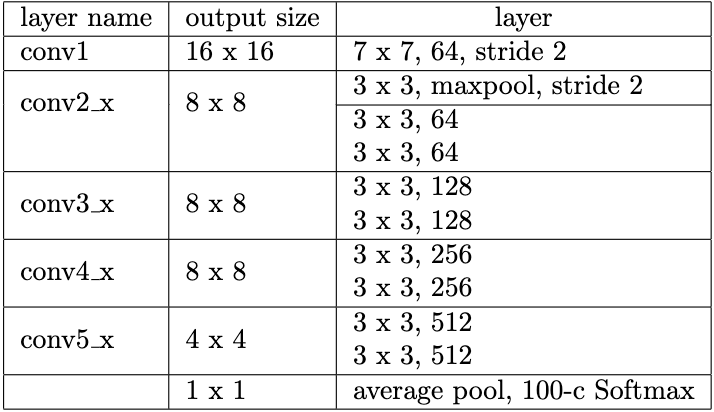


In [21]:


class BasicBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1, downsample = None,useBatchNorm=False):
        super().__init__()
        
        self.useBatchNorm = useBatchNorm
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.downsample = downsample
        self.stride = stride
        
        if useBatchNorm:
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.bn2 = nn.BatchNorm2d(out_channels)
            
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        
        if self.useBatchNorm:
            out = self.bn1(out)
            
        out = self.relu(out)
        out = self.conv2(out)
        
        if self.useBatchNorm:
            out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
    
        
class ResNet(nn.Module):
    
    def __init__(self, block, num_blocks,num_classes,useBatchNorm=False):
        super().__init__()

        self.in_channels = 64
        self.useBatchNorm = useBatchNorm
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        if useBatchNorm:
            self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1])
        self.layer3 = self._make_layer(block, 256, num_blocks[2])
        self.layer4 = self._make_layer(block, 512, num_blocks[3])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride = 1):
        downsample = None

        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, stride),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample,))
        self.in_channels = out_channels
        
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels,out_channels,))

        return nn.Sequential(*layers)
    
    def forward(self, x):

        out = self.conv1(x)
        
        if self.useBatchNorm:
            out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [22]:
learning_rate = 1e-3

model = None
optimize = None


model = ResNet(BasicBlock,[1,1,1,2],100,useBatchNorm=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


print_every = 700
train_part34(model, optimizer, epochs=10)
print_every = 100

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0, Iteration 700, loss = 3.1661
Checking accuracy on validation set
Got 228 / 1000 correct (22.80)

Epoch 1, Iteration 700, loss = 2.6312
Checking accuracy on validation set
Got 325 / 1000 correct (32.50)

Epoch 2, Iteration 700, loss = 2.3416
Checking accuracy on validation set
Got 390 / 1000 correct (39.00)

Epoch 3, Iteration 700, loss = 2.2754
Checking accuracy on validation set
Got 405 / 1000 correct (40.50)

Epoch 4, Iteration 700, loss = 1.3642
Checking accuracy on validation set
Got 444 / 1000 correct (44.40)

Epoch 5, Iteration 700, loss = 1.8748
Checking accuracy on validation set
Got 429 / 1000 correct (42.90)

Epoch 6, Iteration 700, loss = 1.7860
Checking accuracy on validation set
Got 477 / 1000 correct (47.70)

Epoch 7, Iteration 700, loss = 1.8245
Checking accuracy on validation set
Got 472 / 1000 correct (47.20)

Epoch 8, Iteration 700, loss = 1.9143
Checking accuracy on validation set
Got 491 / 1000 correct (49.10)

Epoch 9, Iteration 700, loss = 1.2115
Checking

## BatchNorm

Now you will also introduce the Batch-Normalization layer within the Resnet architecture implemented above. Please add a batch normalization layer after each conv in your network before applying the activation function (i.e. the order should be conv->BatchNorm->Relu). Please read the section 3.4 from the Resnet paper (https://arxiv.org/pdf/1512.03385.pdf. 


In [23]:
learning_rate = 1e-3

model = None
optimizer = None


model = ResNet(BasicBlock,[1,1,1,2],100,useBatchNorm=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


print_every = 700
train_part34(model, optimizer, epochs=10)
print_every = 100

Epoch 0, Iteration 700, loss = 3.0838
Checking accuracy on validation set
Got 234 / 1000 correct (23.40)

Epoch 1, Iteration 700, loss = 2.6489
Checking accuracy on validation set
Got 316 / 1000 correct (31.60)

Epoch 2, Iteration 700, loss = 2.2489
Checking accuracy on validation set
Got 362 / 1000 correct (36.20)

Epoch 3, Iteration 700, loss = 2.1380
Checking accuracy on validation set
Got 429 / 1000 correct (42.90)

Epoch 4, Iteration 700, loss = 2.3221
Checking accuracy on validation set
Got 464 / 1000 correct (46.40)

Epoch 5, Iteration 700, loss = 1.7202
Checking accuracy on validation set
Got 447 / 1000 correct (44.70)

Epoch 6, Iteration 700, loss = 1.4302
Checking accuracy on validation set
Got 491 / 1000 correct (49.10)

Epoch 7, Iteration 700, loss = 1.4512
Checking accuracy on validation set
Got 474 / 1000 correct (47.40)

Epoch 8, Iteration 700, loss = 1.4859
Checking accuracy on validation set
Got 498 / 1000 correct (49.80)

Epoch 9, Iteration 700, loss = 1.2144
Checking

BatchNorm normalizes the activations of each mini batch using mean and standard deviation. We do it to improve training stability, converge faster and reduce overfitting. This helps the model to improve its performance. However, the effect of BatchNorm also depends on the architechture of the model we are using. As in this case we can see that there is a increase in accuracy but not as significant.

## Batch Size

We will see the effect of batch size on performance of ResNet (with BatchNorm). 

Specifically, we will try batch sizes of 32, 64 and 128 and describe the effect of varying batch size. You should print the validation accuracy of using each batch size in different rows.

In [24]:
print_every = 9999
batch_sizes = [32, 64, 128]
learning_rate = 1e-3
model = None
optimizer = None

accuracies = []
for batch_size in batch_sizes:
    
    loader_train = DataLoader(cifar100_train, batch_size=batch_size, num_workers=2,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
    
    loader_val = DataLoader(cifar100_val, batch_size=batch_size, num_workers=2, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

    model = ResNet(BasicBlock,[1,1,1,2],100,useBatchNorm=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    accuracy = train_part34(model, optimizer, epochs =10)
    accuracies.append(accuracy)
    

for i, accuracy in enumerate(accuracies):
    print(f"Batch size {batch_sizes[i]}: {accuracy*100}")

print_every = 100

Checking accuracy on validation set
Got 482 / 1000 correct (48.20)
Checking accuracy on validation set
Got 490 / 1000 correct (49.00)
Checking accuracy on validation set
Got 492 / 1000 correct (49.20)
Batch size 32: 0.482
Batch size 64: 0.49
Batch size 128: 0.492



The batch size affects computational efficiency, memory requirements, generalization and gradient estimation. Larger batch sizes utilize parallel processing, but smaller batch sizes introduce more stochasticity and noise for better generalization. Appropriate batch size depends on various factors, including the dataset size, model complexity and available computational resources. As in this case, we can see that the batch size helps improve the accuracy but not as much.
